# Marching Squares Algorithm

In [2]:
!pip install matplotlib
import matplotlib
import matplotlib.pyplot as plt                 # This will import plotting module
import numpy as np
import PIL
from PIL import Image, ImageFile


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\tahol\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
!pip install opencv-python



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\tahol\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


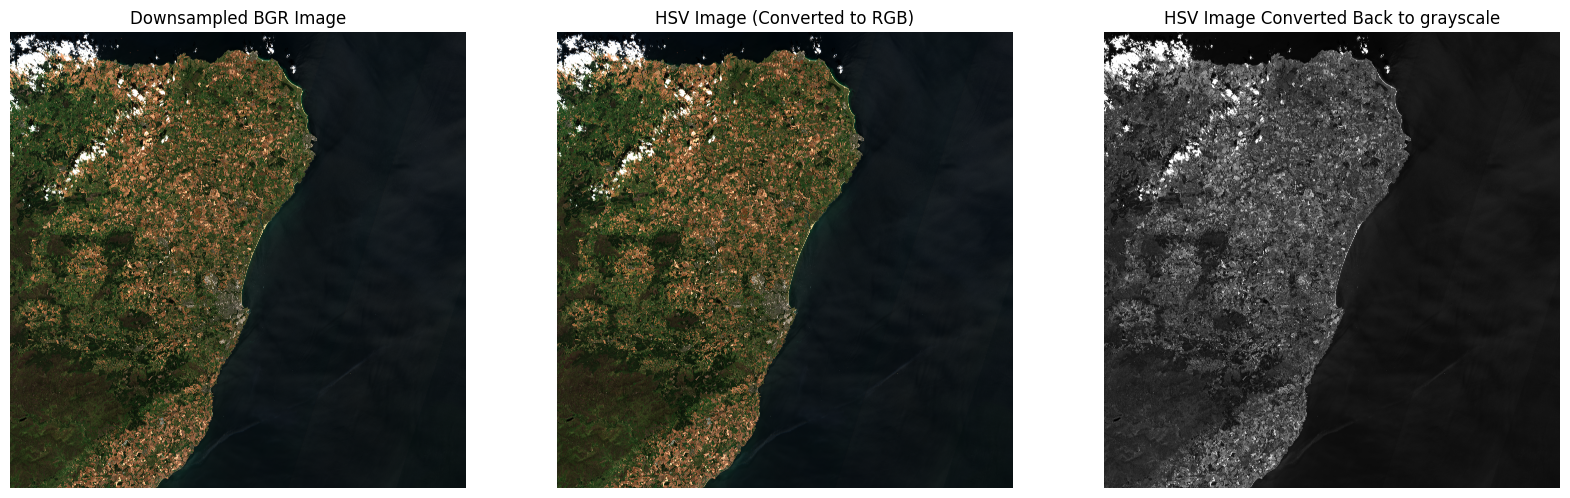

<Figure size 640x480 with 0 Axes>

In [4]:
import cv2

image_bgr = cv2.imread("Aberdeenshire.tif")

downsample_factor = 1
iso_value = [80,180]

new_size = (int(image_bgr.shape[0]*downsample_factor), int(image_bgr.shape[1]*downsample_factor))

#Downsample the image
image_resized = cv2.resize(image_bgr, new_size, interpolation=cv2.INTER_AREA)     

#Convert BGR image to HSV image
image_hsv = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)

# Convert the HSV image back to BGR for displaying
image_bgr_again = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)

image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
                          

# Display the images using matplotlib
plt.figure(figsize=(20, 10))

# Display the original downsampled BGR image
plt.subplot(1, 3, 1)
plt.title('Downsampled BGR Image')
plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display the HSV image (converted to RGB for visualization)
plt.subplot(1, 3, 2)
plt.title('HSV Image (Converted to RGB)')
plt.imshow(cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB))
plt.axis('off')

# Display the HSV image converted back to BGR
plt.subplot(1, 3, 3)
plt.title('HSV Image Converted Back to grayscale')
plt.imshow(image_gray, cmap = "gray")
plt.axis('off')

plt.show()
plt.savefig("aberdeenshire")

## Image Thresholding

we now have an array that has two dimensions for the dimensions of the image, however the 3rd dimension is an rgb channel. The next task is to find a way to distinguish rgb values of land and sea.
First attempt will be to calculate the ratio between blue and green and if this is less than 1 then it must be land (predominantly green) and if greater than 1 then must be sea (predominantly blue)

In [33]:

# Binary thresholding based on the iso_value range for the Hue channel
hue_channel = image_hsv[:, :, 0]
binary_matrix = ((hue_channel > iso_value[0]) & (hue_channel < iso_value[1])).astype(int)

print(binary_matrix)
print(binary_matrix.shape)


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
(10980, 10980)


Alternatively try using the otsu method to find a more accurate threshold value which will be based on the frequency of colour hues to segment the image.


Otsu's algorithm implementation thresholding result:  64.677734375


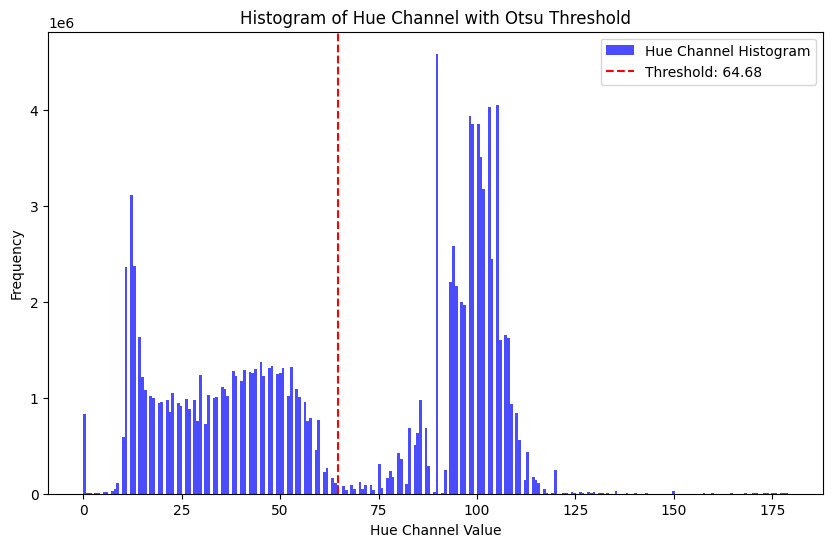

In [34]:
#using the hue channel array.

bins_num = 256
hist, bin_edges = np.histogram(hue_channel, bins = bins_num)
bin_mids = (bin_edges[:-1] + bin_edges[1:])/2

weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

# Get the class means mu0(t)
mean1 = np.cumsum(hist * bin_mids) / weight1
# Get the class means mu1(t)
mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]
 
inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
 
# Maximize the inter_class_variance function val
index_of_max_val = np.argmax(inter_class_variance)
 
threshold = bin_mids[:-1][index_of_max_val]
print("Otsu's algorithm implementation thresholding result: ", threshold)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(hue_channel.ravel(), bins=bins_num, color='blue', alpha=0.7, label='Hue Channel Histogram')

# Plot the threshold line
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.2f}')

# Add labels and title
plt.xlabel('Hue Channel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Hue Channel with Otsu Threshold')
plt.legend()

# Show the plot
plt.show()

Obtained threshold:  65.0


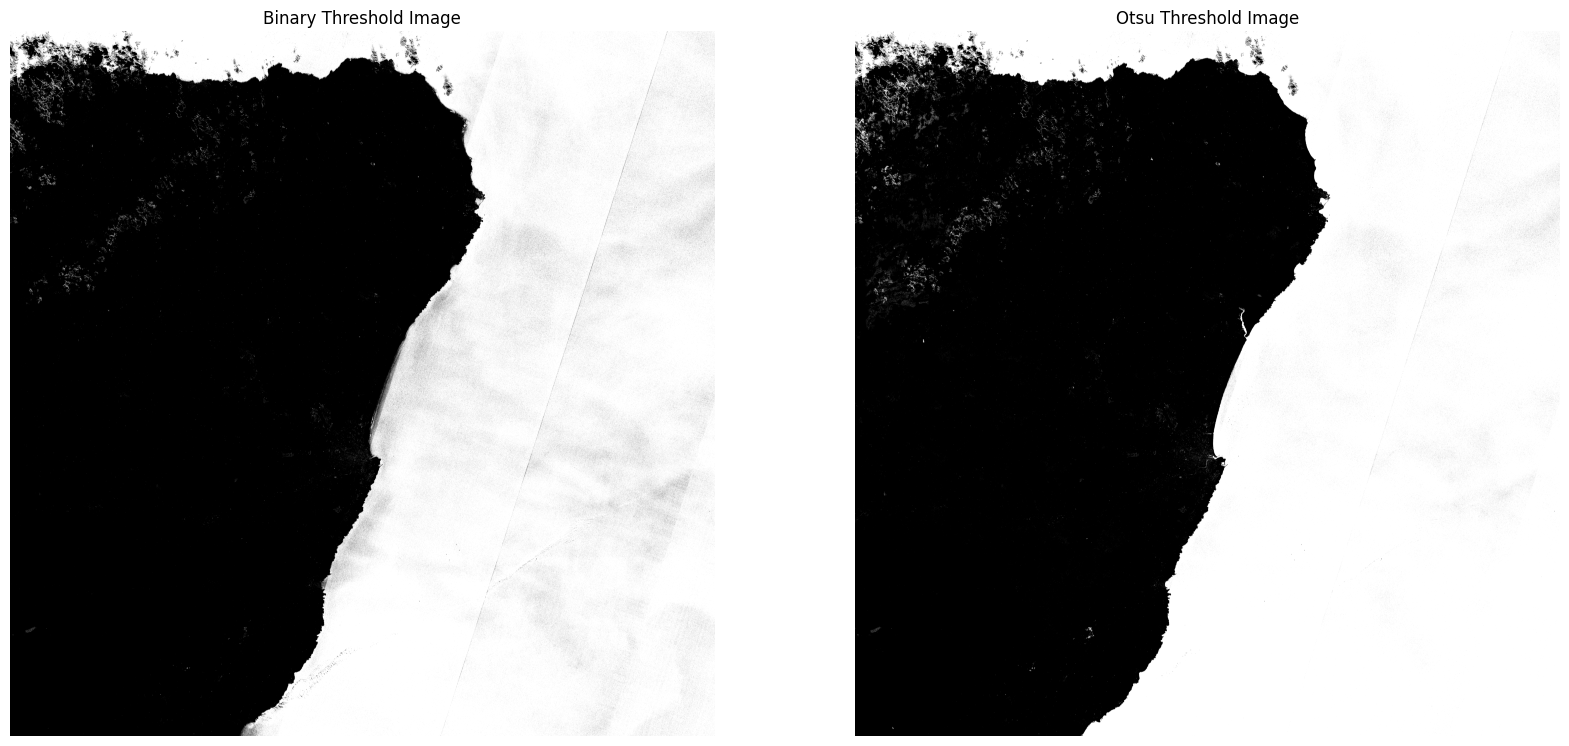

In [35]:
otsu_threshold, image_result = cv2.threshold(
    hue_channel, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU,
)
print("Obtained threshold: ", otsu_threshold)

# Display the HSV image converted back to BGR
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title("Binary Threshold Image")
plt.imshow(binary_matrix, cmap = "gray")
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Otsu Threshold Image")
plt.imshow(image_result, cmap = "gray")
plt.axis('off')

plt.show()


### K Space Clustering
Next we are going to try K space clustering.

(1098, 1098, 3)


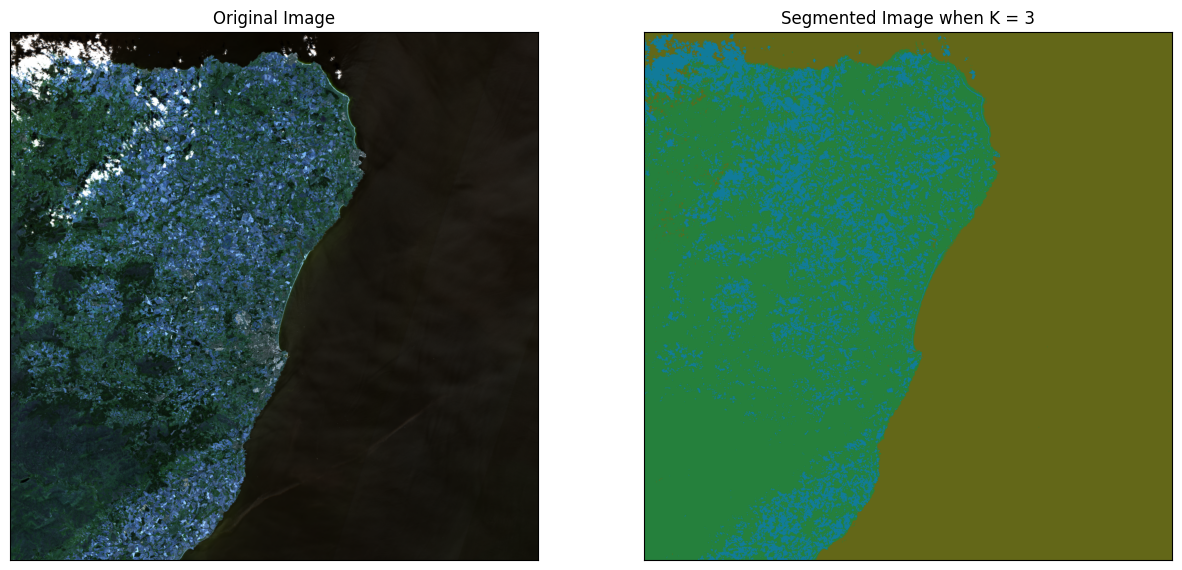

In [8]:
vectorized = image_hsv.reshape((-1,3))
vectorized = np.float32(vectorized)

criteria = (cv2.TermCriteria_EPS +cv2.TermCriteria_MAX_ITER, 10, 1.0)

K = 3
attempts = 10
ret, label, center = cv2.kmeans(vectorized,K,None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((image_resized.shape))
print(result_image.shape)
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(image_resized)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

In [10]:
bins_num = 256
hue_channel = result_image[:,:,0]
hist, bin_edges = np.histogram(hue_channel, bins = bins_num)
bin_mids = (bin_edges[:-1] + bin_edges[1:])/2

weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

# Get the class means mu0(t)
mean1 = np.cumsum(hist * bin_mids) / weight1
# Get the class means mu1(t)
mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]
 
inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
 
# Maximize the inter_class_variance function val
index_of_max_val = np.argmax(inter_class_variance)
 
threshold = bin_mids[:-1][index_of_max_val]
otsu_threshold, result_image = cv2.threshold(
    hue_channel, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU,
)
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(image_resized)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image,cmap = "gray")
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

## Creating a  2d grid for points to lie on:
For the marching Squares Algorithm the points should lie in hte centre of a 2x2 square grid. Hence the size of this grid will be a factor of $2n+1$ bigger than the original image.

Converting the 1s to black spots and the 0s to white spots by getting the position of 1s and 0s. The coordinate system will be defined as the origin in the bottom left.

In [36]:
black = []
white = []

def sort_key(point):
    return point[1] * 100 + point[0] # multiplication ensures that the y has a higher weight in the sorting process (1,0) comes before (0,1) and 

x = image_result.shape[0]-1
y = image_result.shape[1]-1

for i in range(x+1):
    for j in range(y+1):
        if image_result[i][j]==1:
            black.append([j,x-i])
        else:
            white.append([j,x-i])

black = np.array(black)*2 + 1
white = np.array(white)*2 + 1

xblack = [point[0] for point in black]
yblack = [point[1] for point in black]

xwhite = [point[0] for point in white]
ywhite = [point[1] for point in white]

state = {tuple(point): True for point in black}
state.update({tuple(point): False for point in white})
sorted_dict = sorted(state.items(), key=lambda x: sort_key(x[0]))
state_dict = dict(sorted_dict)
print(xblack)

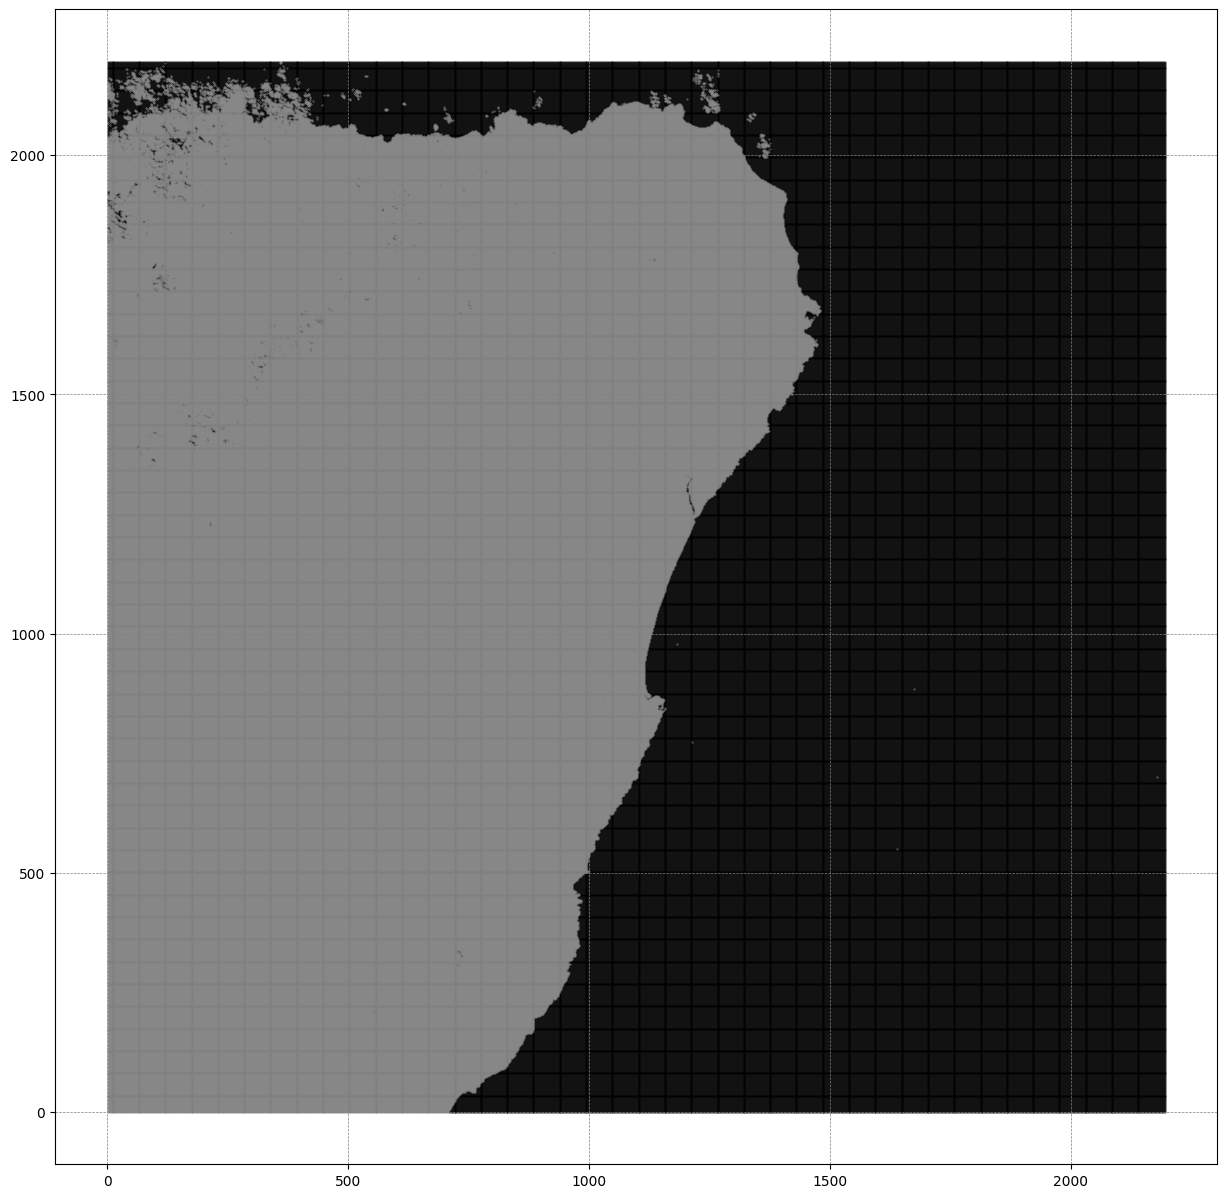

In [25]:
plt.figure(figsize = (15,15))

plt.scatter(xblack,yblack, color = "black",s = 0.1)
plt.scatter(xwhite,ywhite, edgecolors = "grey", color = "grey", s = 0.1)

plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray')

#plt.axis("off")~
plt.show()


The next stage of the algorithm is to assign numbered values to the spaces in between each point. This will be done by dividing the grid into 2x2 subgrids each with a point (black or white) in the corners. These four corners shall be given a bit number 1,2,4 and 8. If a corner is black (True) its associated bit value will be added to the sum and then this sum is stored as the identity for that subgrid. This will result in 16 possible values (0-15) that the subgrid can be assigned.

In [26]:
value = []
def get_value(i,j):
    A = int(state_dict[(i    , j    )])
    B = int(state_dict[(i + 2, j    )])
    C = int(state_dict[(i    , j + 2)])
    D = int(state_dict[(i + 2, j + 2)])
    return A + B*2 + C*4 + D*8

values = {}

x_len = max(xblack+xwhite)
y_len = max(yblack+ywhite)

for j in range(1,y_len,2):
    for i in range(1,x_len,2):
        values.update({(i+1,j+1) : get_value(i,j)})
        

## Contour Lines

There are 15 possible cases that are number dependent, these correspond to the shape of the contour line. A diagram displaying this can be seen below.
![CasesMarchingSquares.jpeg](CasesMarchingSquares.jpeg)

In [27]:
def Segment(start,end):
    plt.plot([start[0],end[0]],[start[1],end[1]],color = "blue")
    return start,end

def generate_edges(i,j,index):
    x,y = i,j 
    vector = []
    if index == 0 or index == 15:
        return 
    elif index == 1 or index == 14:
        start = (x+1,y)
        end = (x,y+1)
        vector.append(Segment(start,end))
    elif index == 2 or index == 13:
        start = (x+1,y)
        end = (x+2,y+1)
        vector.append(Segment(start,end))
    elif index == 3 or index == 12:
        start = (x,y+1)
        end = (x+2,y+1)
        vector.append(Segment(start,end))
    elif index == 7 or index == 8:
        start = (x+2,y+1)
        end = (x+1,y+2)
        vector.append(Segment(start,end))
    elif index == 9:
        start = (x,y+1)
        end = (x+1,y+2)
        vector.append(Segment(start,end))
        start = (x+1,y)
        end = (x+2,y+1)
        vector.append(Segment(start,end))
    elif index == 5 or index == 10:
        start = (x+1,y)
        end = (x+1,y+2)
        vector.append(Segment(start,end))
    elif index == 4 or index == 11:
        start = (x,y+1)
        end = (x+1,y+2)
        vector.append(Segment(start,end))
    elif index == 6:
        start = (x+2,y+1)
        end = (x+1,y+2)
        vector.append(Segment(start,end))
        start = (x+1,y)
        end = (x,y+1)
        vector.append(Segment(start,end))
        
    return vector

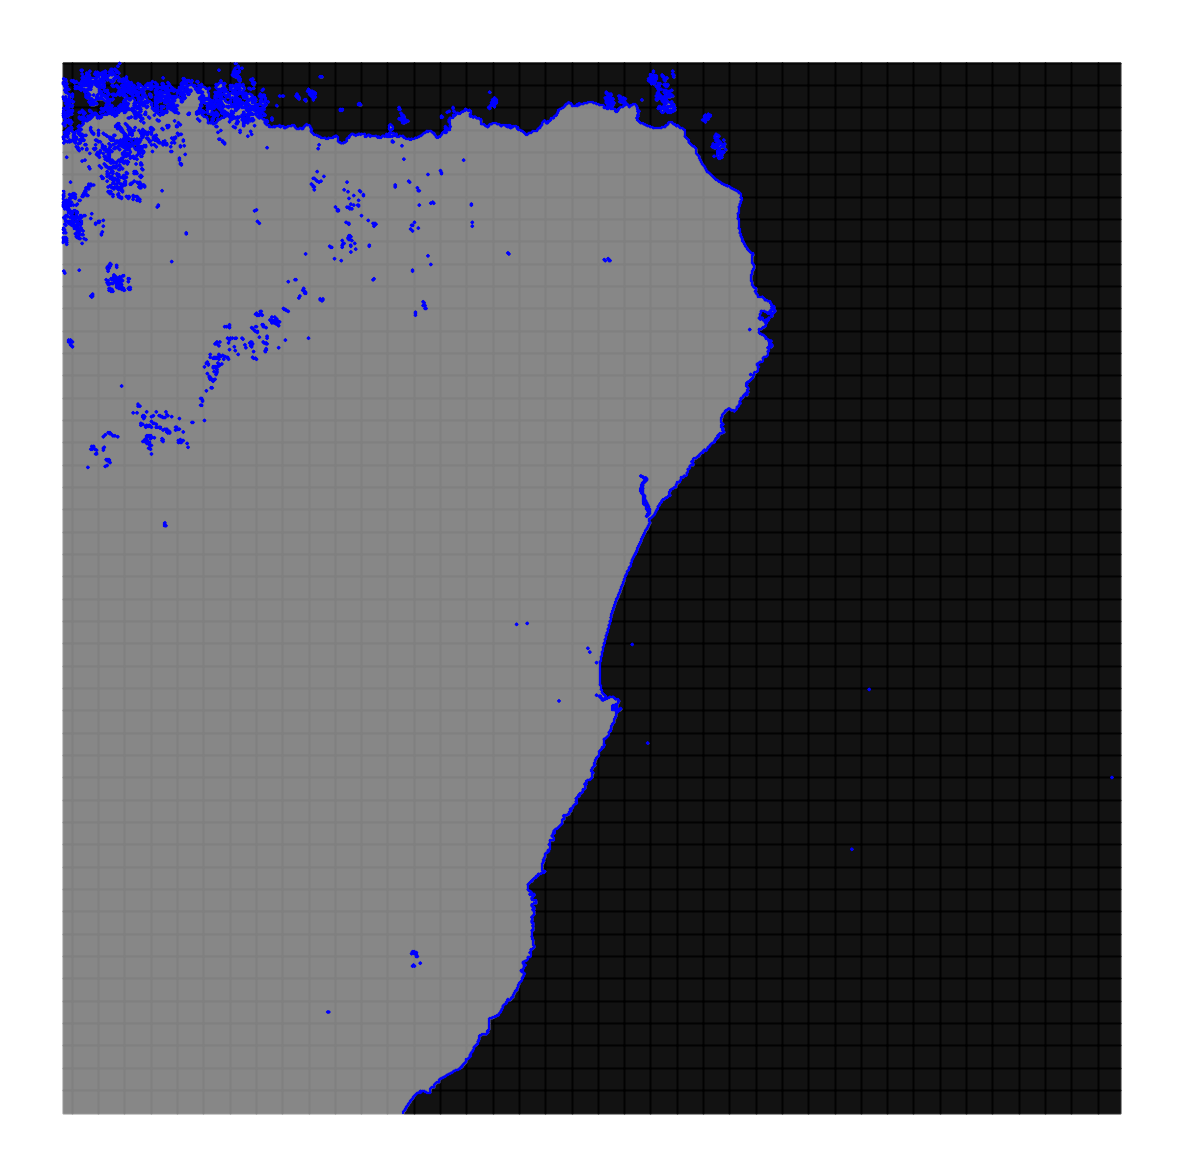

In [28]:
plt.figure(figsize = (15,15))

plt.scatter(xblack,yblack, color = "black", s = 0.1)
plt.scatter(xwhite,ywhite, edgecolors = "grey", color = "grey", s=0.1)

x_len = max(xblack+xwhite)
y_len = max(yblack+ywhite)

values = {}

vectors = []

for j in range(1,y_len,2):
    for i in range(1,x_len,2):
        index = get_value(i,j)
        #values.update({(i+1,j+1) : index})
        if index == 6 or index == 9:
            double_vec = generate_edges(i,j,index)
            vectors.append([double_vec[0]])
            vectors.append([double_vec[1]])
        else:
            vectors.append(generate_edges(i,j,index))

plt.axis("off")
# plt.xlim(1000,1100)
# plt.ylim(2000,2200)
plt.show()

vectors = [x for x in vectors if x is not None] #filtering None values

## Split into vector shapes

Need to split into seperate vectors, so if a points starting point matches with another points end point then those points will be stored together in one vector. 
1. Choose first point in array and take note of its start and end point
2. Put these into a shape array
3. Loop through the vector array to see if there is a segment who's starting or end point that is the same as the shape point being compared to.
4. If true then pop out the two vertices and store in a vector and repeat with the new end point from the second segment.
5. If false then pop out the two vertices and look at the next element in the array and repeat the process.

In [29]:
# Initialize empty list to store shapes
shapes = []

# Initialize set to keep track of indices of vectors that need to be removed
indices_to_remove = set(range(len(vectors)))

# Iterate until there are no more vectors to process
while indices_to_remove:
    # Initialize a new shape
    shape = []
    
    # Get the first vector and extract the tuple of points
    vector = vectors[indices_to_remove.pop()][0]  # Get the tuple from the list
    start_point, end_point = vector  # Unpack the tuple

    # Add the start and end points to the shape
    shape.extend([start_point, end_point])

    # Flag to check if a match is found
    matched = True
    
    # Continue until no more matches are found
    while matched:
        # Reset match flag
        matched = False
        # Iterate through indices of vectors to remove
        for idx in list(indices_to_remove):
            # Get the vector at the current index and extract the tuple of points
            vec = vectors[idx][0]  # Extract the tuple

            # Check if the vector connects to the shape
            if vec[0] == end_point:
                # Append the matching vector's end point
                end_point = vec[1]
                shape.append(end_point)
                indices_to_remove.remove(idx)
                matched = True
                break
            elif vec[1] == end_point:
                # Append the matching vector's start point (reverse match)
                end_point = vec[0]
                shape.append(end_point)
                indices_to_remove.remove(idx)
                matched = True
                break
            elif vec[0] == start_point:
                # If the start of the shape matches a vector, prepend it
                start_point = vec[1]
                shape.insert(0, start_point)  # Add to the beginning of the shape
                indices_to_remove.remove(idx)
                matched = True
                break
            elif vec[1] == start_point:
                # If the start of the shape matches a reversed vector, prepend it
                start_point = vec[0]
                shape.insert(0, start_point)
                indices_to_remove.remove(idx)
                matched = True
                break

    # Add the completed shape to the list of shapes
    shapes.append(shape)


In [30]:
shapes = sorted(shapes, key = lambda shape: len(shape), reverse=True)
coastline_vector = shapes[0]
coastline_vector2 = shapes[1]
coastline_vector3 = shapes[2]
xcoords = []
ycoords = []

print(shapes[-1])
for point in coastline_vector:
    xcoords.append(point[0])
    ycoords.append(point[1])



[(1, 2152), (2, 2153), (1, 2154)]


<function matplotlib.pyplot.show(close=None, block=None)>

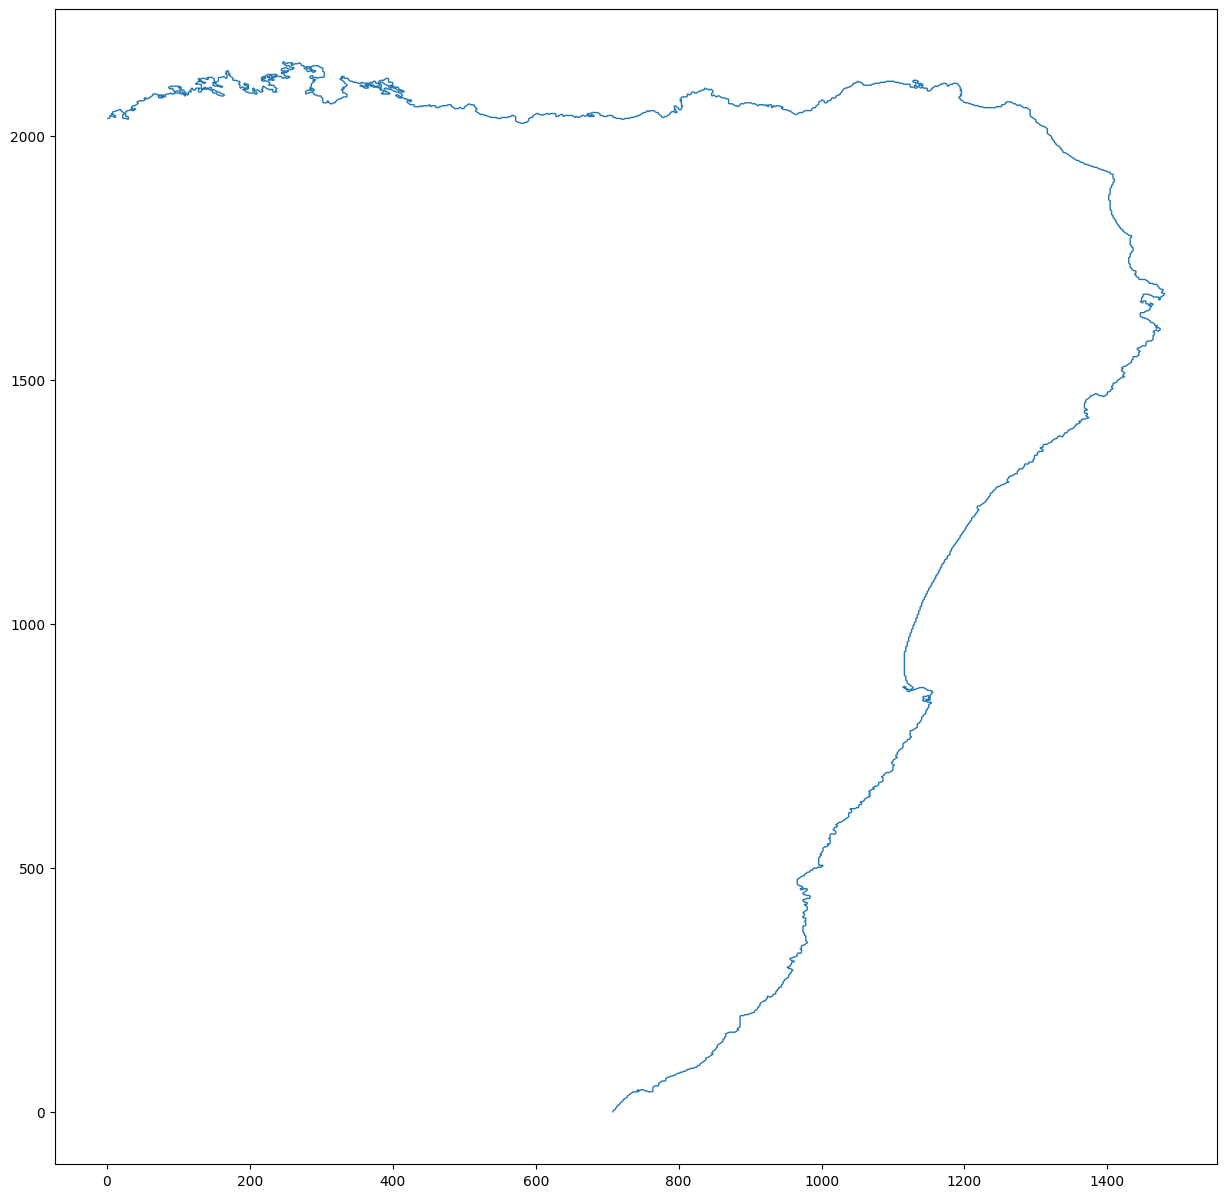

In [31]:
plt.figure(figsize = (15,15))

# plt.scatter(xblack,yblack, color = "black")
# plt.scatter(xwhite,ywhite, edgecolors = "black", color = "white")
for i in range(1):
    coastline_vector = shapes[i]
    xcoords = []
    ycoords = []
    for point in coastline_vector:
        xcoords.append(point[0])
        ycoords.append(point[1])
    plt.plot(xcoords,ycoords,linewidth = 1)    
# plt.plot(xcoords,ycoords)

# plt.xlim(700,900)
# plt.ylim(2000,2200)
plt.show

The problem I am now facing is that there appears to be vector shapes that should physically connect to form a distinct coastline-vector however they must share a common pixel perhaps due to the compression and loss of accuracy required to run this program on my laptop. I will now attempt to resolve this by interpolating nearby end points of vectors to produce a singular vector line. 

# End of Programme

### Linear Interpolation

In [20]:
#set isovalue
iso_value = 100
#converts all values greater than the isovalue to a 1 and those below the isovalue to a 0
x,y = A.shape
relative_matrix = np.zeros((x*2+1,y*2+1))
true_state = {}
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if A[i,j] > iso_value:
            relative_matrix[2*i+1,2*j+1] = 1
            true_state.update({(2*i+1,2*j+1):1})
        else:
            relative_matrix[2*i+1,2*j+1] = A[i,j]/iso_value
            true_state.update({(2*i+1,2*j+1):A[i,j]/iso_value})


NameError: name 'A' is not defined

In [ ]:
print(true_state)

{(1, 1): 1, (1, 3): 0.47, (1, 5): 1, (1, 7): 1, (1, 9): 1, (1, 11): 0.25, (1, 13): 1, (1, 15): 0.61, (1, 17): 1, (1, 19): 0.12, (1, 21): 1, (1, 23): 0.03, (1, 25): 1, (1, 27): 0.85, (1, 29): 0.06, (1, 31): 1, (1, 33): 0.26, (1, 35): 1, (1, 37): 0.97, (1, 39): 1, (3, 1): 0.08, (3, 3): 1, (3, 5): 1, (3, 7): 0.02, (3, 9): 0.21, (3, 11): 1, (3, 13): 1, (3, 15): 1, (3, 17): 1, (3, 19): 1, (3, 21): 1, (3, 23): 1, (3, 25): 0.72, (3, 27): 1, (3, 29): 0.42, (3, 31): 0.86, (3, 33): 0.06, (3, 35): 1, (3, 37): 1, (3, 39): 1, (5, 1): 1, (5, 3): 1, (5, 5): 0.61, (5, 7): 1, (5, 9): 1, (5, 11): 0.71, (5, 13): 0.06, (5, 15): 1, (5, 17): 0.82, (5, 19): 1, (5, 21): 1, (5, 23): 1, (5, 25): 1, (5, 27): 1, (5, 29): 1, (5, 31): 1, (5, 33): 0.21, (5, 35): 0.17, (5, 37): 1, (5, 39): 1, (7, 1): 1, (7, 3): 0.52, (7, 5): 0.95, (7, 7): 1, (7, 9): 0.62, (7, 11): 1, (7, 13): 1, (7, 15): 1, (7, 17): 0.69, (7, 19): 0.38, (7, 21): 0.39, (7, 23): 1, (7, 25): 1, (7, 27): 0.58, (7, 29): 0.05, (7, 31): 1, (7, 33): 1, (7, 3

In [ ]:
def Segment(start,end):
    plt.plot([start[0],end[0]],[start[1],end[1]],color = "blue")
    return start,end

def generate_edges(i,j,index):
    x,y = i,j 
    vector = []
    if index == 0 or index == 15:
        return 
    elif index == 1 or index == 14:
        try:
            start = (x+1,y)
            end = (x,y+1)
            Px = x+2*((1-true_state[(x+2,y)])/(true_state[(x,y)]-true_state[(x+2,y)]))
            Py = 0
            Qx = 0
            Qy = y+2*((1-true_state[(x,y+2)])/(true_state[(x,y)]-true_state[(x,y+2)]))
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    elif index == 2 or index == 13:
        try:
            start = (x+1,y)
            end = (x+2,y+1)
            Px = x+2*((1-true_state[(x+2,y)])/(true_state[(x,y)]-true_state[(x+2,y)]))
            Py = 0
            Qx = 2
            Qy = y+2*((1-true_state[(x+2,y+2)])/(true_state[(x+2,y)]-true_state[(x+2,y+2)]))
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    elif index == 3 or index == 12:
        try:
            start = (x,y+1)
            end = (x+2,y+1)
            Px = 0
            Py = y+2*((1-true_state[(x,y+2)])/(true_state[(x,y)]-true_state[(x,y+2)]))
            Qx = 2
            Qy = y+2*((1-true_state[(x+2,y+2)])/(true_state[(x+2,y)]-true_state[(x+2,y+2)]))
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    elif index == 7 or index == 8:
        try:
            start = (x+2,y+1)
            end = (x+1,y+2)
            Px = 2
            Py = y+2*((1-true_state[(x+2,y+2)])/(true_state[(x+2,y)]-true_state[(x+2,y+2)]))
            Qx = x+2*((1-true_state[(x+2,y+2)])/(true_state[(x,y+2)]-true_state[(x+2,y+2)]))
            Qy = 2
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    elif index == 9:
        try:
            start = (x,y+1)
            end = (x+1,y+2)
            Px = 0
            Py = y+2*((1-true_state[(x,y+2)])/(true_state[(x,y)]-true_state[(x,y+2)]))
            Qx = x+2*((1-true_state[(x+2,y+2)])/(true_state[(x,y+2)]-true_state[(x+2,y+2)]))
            Qy = 2
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
            start = (x+1,y)
            end = (x+2,y+1)
            Px = x+2*((1-true_state[(x+2,y)])/(true_state[(x,y)]-true_state[(x+2,y)]))
            Py = 0
            Qx = 0
            Qy = y+2*((1-true_state[(x,y+2)])/(true_state[(x,y)]-true_state[(x,y+2)]))
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    elif index == 5 or index == 10:
        try:
            start = (x+1,y)
            end = (x+1,y+2)
            Px = x+2*((1-true_state[(x+2,y)])/(true_state[(x,y)]-true_state[(x+2,y)]))
            Py = 0
            Qx = x+2*((1-true_state[(x+2,y+2)])/(true_state[(x,y+2)]-true_state[(x+2,y+2)]))
            Qy = 2
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    elif index == 4 or index == 11:
        try:
            start = (x,y+1)
            end = (x+1,y+2)
            Px = 0
            Py = y+2*((1-true_state[(x,y+2)])/(true_state[(x,y)]-true_state[(x,y+2)]))
            Qx = x+2*((1-true_state[(x+2,y+2)])/(true_state[(x,y+2)]-true_state[(x+2,y+2)]))
            Qy = 2
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    elif index == 6:
        try:
            start = (x+2,y+1)
            end = (x+1,y+2)
            Px = 2
            Py = y+2*((1-true_state[(x+2,y+2)])/(true_state[(x+2,y)]-true_state[(x+2,y+2)]))
            Qx = x+2*((1-true_state[(x+2,y+2)])/(true_state[(x,y+2)]-true_state[(x+2,y+2)]))
            Qy = 2
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
            start = (x+1,y)
            end = (x,y+1)
            Px = x+2*((1-true_state[(x+2,y)])/(true_state[(x,y)]-true_state[(x+2,y)]))
            Py = 0
            Qx = 0
            Qy = y+2*((1-true_state[(x,y+2)])/(true_state[(x,y)]-true_state[(x,y+2)]))
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    return vector

In [ ]:
def Segment(start,end):
    plt.plot([start[0],end[0]],[start[1],end[1]],color = "blue")
    return start,end

def generate_edges(i,j,index):
    x,y = i,j 
    vector = []
    if index == 0 or index == 15:
        return 
    elif index == 1 or index == 14:
        try:
            start = (x+1,y)
            end = (x,y+1)
            Px = x+2*((1-true_state[(x,y)])/(true_state[(x+2,y)]-true_state[(x,y)]))
            Py = 0
            Qx = 0
            Qy = y+2*((1-true_state[(x,y)])/(true_state[(x,y+2)]-true_state[(x,y)]))
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    elif index == 2 or index == 13:
        try:
            start = (x+1,y)
            end = (x+2,y+1)
            Px = x+2*((1-true_state[(x,y)])/(true_state[(x+2,y)]-true_state[(x,y)]))
            Py = 0
            Qx = 2
            Qy = y+2*((1-true_state[(x+2,y)])/(true_state[(x+2,y+2)]-true_state[(x+2,y)]))
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    elif index == 3 or index == 12:
        try:
            start = (x,y+1)
            end = (x+2,y+1)
            Px = 0
            Py = y+2*((1-true_state[(x,y)])/(true_state[(x,y+2)]-true_state[(x,y)]))
            Qx = 2
            Qy = y+2*((1-true_state[(x+2,y)])/(true_state[(x+2,y+2)]-true_state[(x+2,y)]))
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    elif index == 7 or index == 8:
        try:
            start = (x+2,y+1)
            end = (x+1,y+2)
            Px = 2
            Py = y+2*((1-true_state[(x+2,y)])/(true_state[(x+2,y+2)]-true_state[(x+2,y)]))
            Qx = x+2*((1-true_state[(x,y+2)])/(true_state[(x+2,y+2)]-true_state[(x,y+2)]))
            Qy = 2
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    elif index == 9:
        try:
            start = (x,y+1)
            end = (x+1,y+2)
            Px = 0
            Py = y+2*((1-true_state[(x,y)])/(true_state[(x,y+2)]-true_state[(x,y)]))
            Qx = x+2*((1-true_state[(x,y+2)])/(true_state[(x+2,y+2)]-true_state[(x,y+2)]))
            Qy = 2
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
            start = (x+1,y)
            end = (x+2,y+1)
            Px = x+2*((1-true_state[(x,y)])/(true_state[(x+2,y)]-true_state[(x,y)]))
            Py = 0
            Qx = 0
            Qy = y+2*((1-true_state[(x,y)])/(true_state[(x,y+2)]-true_state[(x,y)]))
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    elif index == 5 or index == 10:
        try:
            start = (x+1,y)
            end = (x+1,y+2)
            Px = x+2*((1-true_state[(x,y)])/(true_state[(x+2,y)]-true_state[(x,y)]))
            Py = 0
            Qx = x+2*((1-true_state[(x,y+2)])/(true_state[(x+2,y+2)]-true_state[(x,y+2)]))
            Qy = 2
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    elif index == 4 or index == 11:
        try:
            start = (x,y+1)
            end = (x+1,y+2)
            Px = 0
            Py = y+2*((1-true_state[(x,y)])/(true_state[(x,y+2)]-true_state[(x,y)]))
            Qx = x+2*((1-true_state[(x,y+2)])/(true_state[(x+2,y+2)]-true_state[(x,y+2)]))
            Qy = 2
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    elif index == 6:
        try:
            start = (x+2,y+1)
            end = (x+1,y+2)
            Px = 2
            Py = y+2*((1-true_state[(x+2,y)])/(true_state[(x+2,y+2)]-true_state[(x+2,y)]))
            Qx = x+2*((1-true_state[(x,y+2)])/(true_state[(x+2,y+2)]-true_state[(x,y+2)]))
            Qy = 2
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
            start = (x+1,y)
            end = (x,y+1)
            Px = x+2*((1-true_state[(x,y)])/(true_state[(x+2,y)]-true_state[(x,y)]))
            Py = 0
            Qx = 0
            Qy = y+2*((1-true_state[(x,y)])/(true_state[(x,y+2)]-true_state[(x,y)]))
            start = (Px,Py)
            end = (Qx,Qy)
            vector.append(Segment(start,end))
        except (ZeroDivisionError, ValueError):
            print(f'({x,y})')
    return vector

((3, 1))
((5, 1))
((11, 1))
((17, 1))
((19, 1))
((21, 1))
((25, 1))
((27, 1))
((29, 1))
((35, 1))
((37, 1))
((1, 3))
((3, 3))
((13, 3))
((25, 3))
((27, 3))
((29, 3))
((31, 3))
((1, 5))
((7, 5))
((13, 5))
((21, 5))
((23, 5))
((25, 5))
((29, 5))
((31, 5))
((37, 5))
((1, 7))
((3, 7))
((5, 7))
((7, 7))
((15, 7))
((17, 7))
((23, 7))
((25, 7))
((27, 7))
((29, 7))
((31, 7))
((35, 7))
((37, 7))
((7, 9))
((15, 9))
((17, 9))
((19, 9))
((21, 9))
((25, 9))
((27, 9))
((29, 9))
((33, 9))
((35, 9))
((37, 9))
((1, 11))
((3, 11))
((5, 11))
((7, 11))
((9, 11))
((13, 11))
((15, 11))
((17, 11))
((27, 11))
((29, 11))
((33, 11))
((35, 11))
((37, 11))
((1, 13))
((3, 13))
((5, 13))
((7, 13))
((11, 13))
((13, 13))
((15, 13))
((23, 13))
((27, 13))
((29, 13))
((37, 13))
((1, 15))
((3, 15))
((5, 15))
((11, 15))
((13, 15))
((19, 15))
((21, 15))
((23, 15))
((25, 15))
((27, 15))
((29, 15))
((33, 15))
((35, 15))
((37, 15))
((1, 17))
((19, 17))
((21, 17))
((25, 17))
((27, 17))
((29, 17))
((37, 17))
((1, 19))
((17, 19)

C:\Users\tahol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars


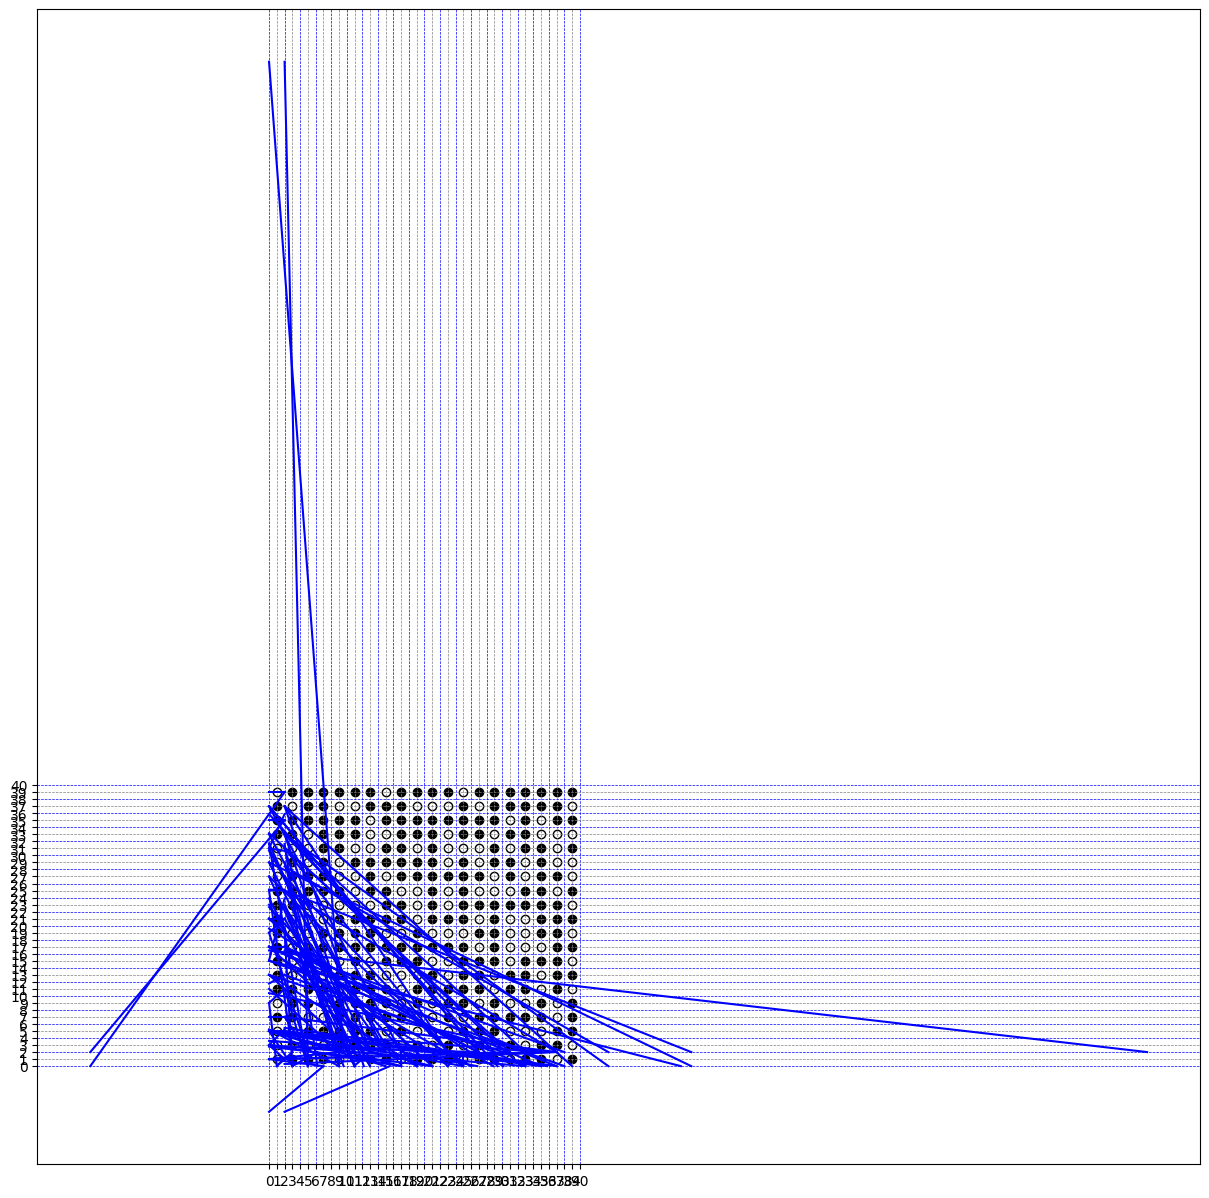

In [ ]:
plt.figure(figsize = (15,15))

plt.scatter(xblack,yblack, color = "black")
plt.scatter(xwhite,ywhite, edgecolors = "black", color = "white")

plt.xticks(range(0, int(max(xblack + xwhite)) + 2))
plt.yticks(range(0, int(max(yblack + ywhite)) + 2))

plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray')

x_counter = 0
y_counter = 0

x_coords, y_coords = zip(*values.keys())
z_values = list(values.values())

# for i, txt in enumerate(z_values):
#     plt.annotate(txt, (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0,0), ha='center')
    
for tick in plt.gca().xaxis.get_major_ticks():
    if x_counter % 2 == 0:
        tick.gridline.set_color('blue')  # Change color for even x values
    else:
        tick.gridline.set_color('gray')
    x_counter += 1
for tick in plt.gca().yaxis.get_major_ticks():
    if y_counter % 2 == 0:
        tick.gridline.set_color('blue')  # Change color for even y values
    else:
        tick.gridline.set_color('gray')  
    y_counter += 1    

x_len = max(xblack+xwhite)
y_len = max(yblack+ywhite)

values = {}

vectors = []

for j in range(1,y_len,2):
    for i in range(1,x_len,2):
        index = get_value(i,j)
        values.update({(i+1,j+1) : index})
        vectors.append(generate_edges(i,j,index))
plt.show()

vectors = [x for x in vectors if x is not None] #filtering None values